In [ ]:
!git clone https://github.com/WongKinYiu/yolov7

In [1]:
#!mv /kaggle/working/data1 /kaggle/working/yolov7

In [3]:
%cd yolov7

/kaggle/working/yolov7


In [23]:
FILE_ROOT = "/kaggle/input/car-plate-detection/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

### **Create data yaml file**

In [ ]:
!echo "train: Dataset/train/images" > data/alpr.yaml
!echo "val:   Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license']" >> data/alpr.yaml

!cat data/alpr.yaml

### **Download Weights**

In [ ]:
!mkdir -p weights

In [7]:
!rm -r yolov7

rm: cannot remove 'yolov7': No such file or directory


In [5]:
%ls yolov7

LICENSE.md  deploy/    hubconf.py  requirements.txt  train.py
README.md   detect.py  inference/  scripts/          train_aux.py
cfg/        export.py  models/     test.py           utils/
data/       figure/    paper/      tools/


In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

In [ ]:
%cd /kaggle/working/yolov7

### **Prepare data**

In [ ]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [ ]:
!mkdir -p Dataset/train/labels

In [ ]:
# copy images
!mkdir -p Dataset/train
!cp -rf /kaggle/input/car-plate-detection/images Dataset/train

In [ ]:
!mkdir -p Dataset/val
!cp -rf /kaggle/input/car-plate-detection/images/Cars1*.png Dataset/val

In [ ]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

In [ ]:
!mkdir -p Dataset/val/labels
!cp -rf Dataset/train/labels/Cars1*.txt Dataset/val/labels

In [1]:
%pip install -q wandb
import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Multiple GPU training

In [ ]:
#!python -m torch.distributed.launch --nproc_per_node 2 train.py --device 0,1 --workers 8 --device 0 --batch-size 32 --epochs 100 --data data/alpr.yaml --img 416 416 --cfg cfg/training/yolov7.yaml --weights 'weights/yolov7_training.pt' --name yolov7-alpr --hyp data/hyp.scratch.p5.yaml

Single GPU training

In [4]:
!python train.py --workers 8 --device 0 --batch-size 16 --epochs 100 --data data/alpr.yaml --img 416 416 --cfg cfg/training/yolov7.yaml --weights 'weights/yolov7_training.pt' --name yolov7-alpr --hyp data/hyp.scratch.p5.yaml

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
wandb: Currently logged in as: milan-szabom (elte-ai). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.0
wandb: Run data is saved locally in /kaggle/working/yolov7/wandb/run-20230508_124917-viueu3r9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run yolov7-alpr6
wandb: ⭐️ View project at https://wandb.ai/elte-ai/YOLOR
wandb: 🚀 View run at https://wandb.ai/elte-ai/YOLOR/runs/viueu3r9
train: Scanning 'Dataset/train/labels.cache' images and labels... 433 found, 0 m
val: Scanning 'Dataset/train/labels.cache' images and labels... 433 found, 0 mis

autoanchor: Analyzing anchors... anchor

### **Detect License Plates**

In [3]:
%ls yolov7/runs

detect/  train/


In [ ]:
%rm -r yolov7-alpr

In [5]:
BEST_MODEL_PATH = 'runs/train/yolov7-alpr6/weights/best.pt'

In [36]:
# Download OpenALPR Benchmarks
%cd ..
!git clone https://github.com/openalpr/benchmarks

/kaggle/working
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1752 (delta 22), reused 22 (delta 22), pack-reused 1728
Receiving objects: 100% (1752/1752), 187.98 MiB | 33.81 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [2]:
%cd yolov7

/kaggle/working/yolov7


In [67]:
%ls runs/train/yolov7-alpr2/weights/best.pt

best.pt  epoch_000.pt  init.pt  last.pt


In [6]:
!python detect.py --source ../benchmarks/endtoend/us --conf 0.4 --weights $BEST_MODEL_PATH --save-txt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Namespace(weights=['runs/train/yolov7-alpr6/weights/best.pt'], source='../benchmarks/endtoend/us', img_size=640, conf_thres=0.4, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/AT

In [21]:
!python detect.py --source ../benchmarks/endtoend/eu --conf 0.4 --weights $BEST_MODEL_PATH --save-txt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Namespace(weights=['runs/train/yolov7-alpr6/weights/best.pt'], source='../benchmarks/endtoend/eu', img_size=640, conf_thres=0.4, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src

In [24]:
!python detect.py --source ../benchmarks/endtoend/br --conf 0.4 --weights $BEST_MODEL_PATH --save-txt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Namespace(weights=['runs/train/yolov7-alpr6/weights/best.pt'], source='../benchmarks/endtoend/br', img_size=640, conf_thres=0.4, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src

### **Display Images**

In [17]:
from IPython.display import Image

In [19]:
%rm -r runs/detect

In [15]:
%ls runs/detect

exp/  exp2/  exp3/


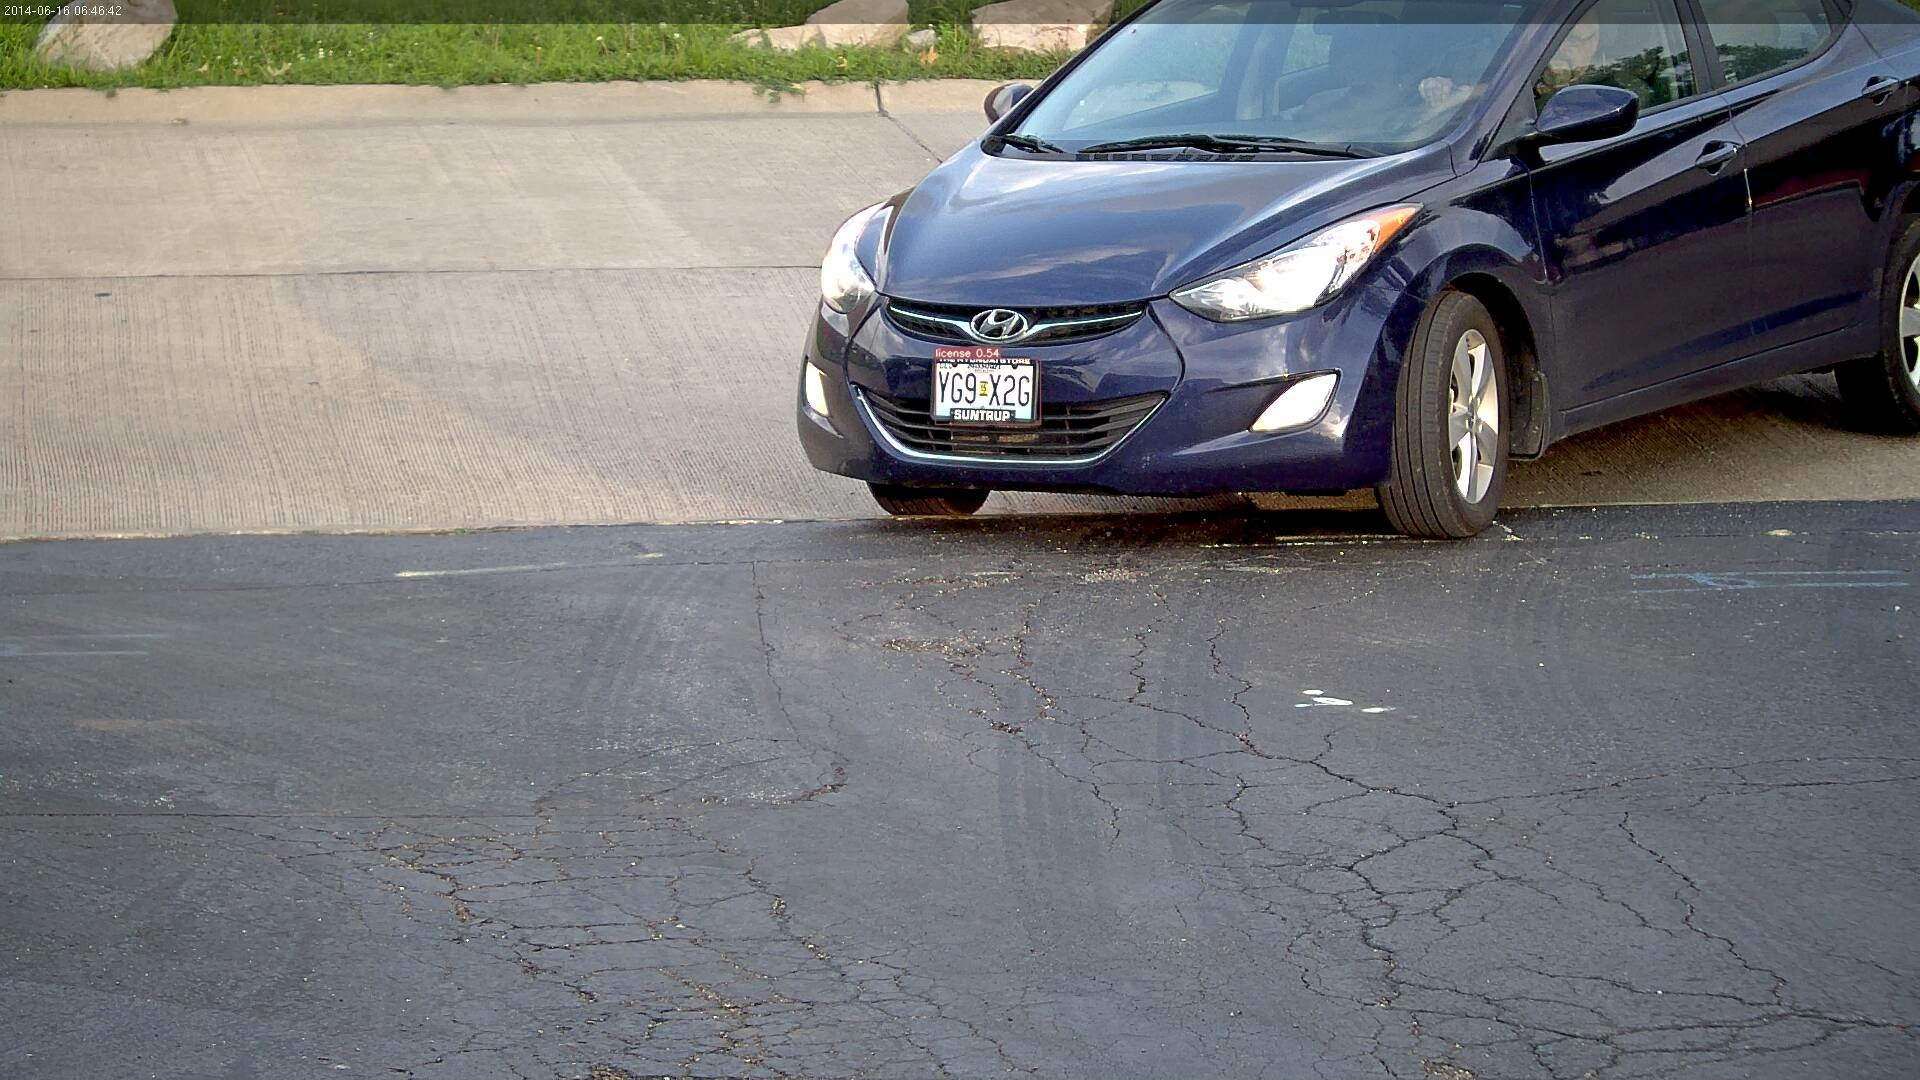

In [27]:
Image('runs/detect/exp/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg')

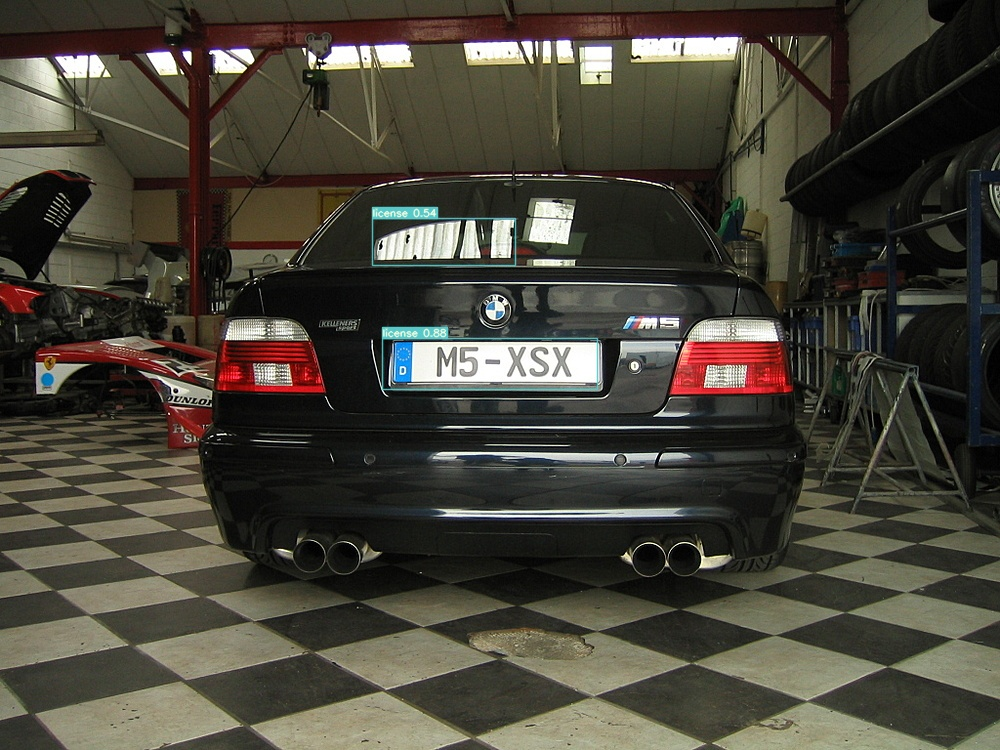

In [34]:
Image('runs/detect/exp2/eu1.jpg')

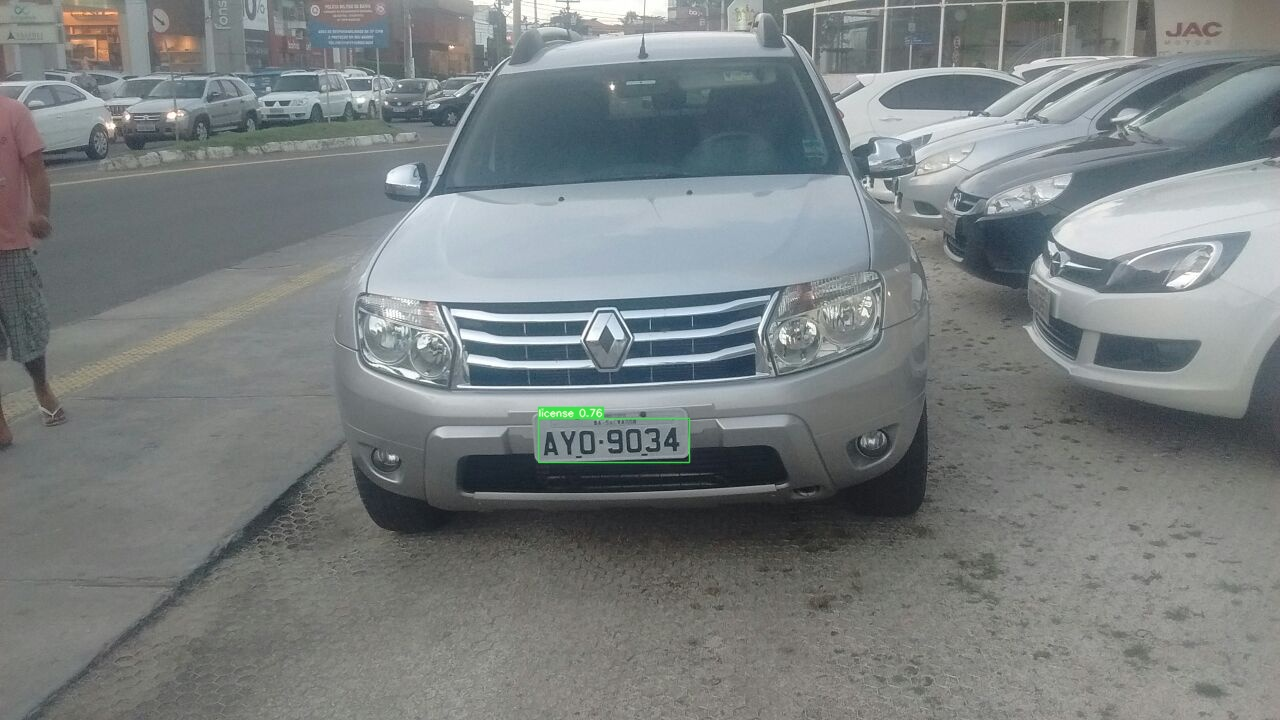

In [26]:
Image('runs/detect/exp5/AYO9034.jpg')

In [4]:
%cd working

[Errno 2] No such file or directory: 'working'
/kaggle/working


In [ ]:
!zip -r license_plate.zip yolov7

updating: yolov7/ (stored 0%)
  adding: yolov7/requirements.txt (deflated 50%)
  adding: yolov7/tools/ (stored 0%)
  adding: yolov7/tools/compare_YOLOv7_vs_YOLOv5m6_half.ipynb (deflated 42%)
  adding: yolov7/tools/compare_YOLOv7_vs_YOLOv5m6.ipynb (deflated 42%)
  adding: yolov7/tools/YOLOv7onnx.ipynb (deflated 25%)
  adding: yolov7/tools/visualization.ipynb (deflated 25%)
  adding: yolov7/tools/reparameterization.ipynb (deflated 93%)
  adding: yolov7/tools/compare_YOLOv7e6_vs_YOLOv5x6_half.ipynb (deflated 41%)
  adding: yolov7/tools/YOLOv7-Dynamic-Batch-TENSORRT.ipynb (deflated 28%)
  adding: yolov7/tools/YOLOv7CoreML.ipynb (deflated 34%)
  adding: yolov7/tools/YOLOv7trt.ipynb (deflated 35%)
  adding: yolov7/tools/compare_YOLOv7_vs_YOLOv5s6.ipynb (deflated 42%)
  adding: yolov7/tools/compare_YOLOv7e6_vs_YOLOv5x6.ipynb (deflated 41%)
  adding: yolov7/tools/keypoint.ipynb (deflated 25%)
  adding: yolov7/tools/instance.ipynb (deflated 25%)
  adding: yolov7/tools/YOLOv7-Dynamic-Batch-ONNXR

In [18]:
!ls

__notebook_source__.ipynb  benchmarks  license_plate.zip  yolov7
